In [ ]:
import json
import requests
import datetime
import pandas as pd
import numpy as np
import boto3
from io import StringIO
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib

## Puxando dados e criando df

In [ ]:
# Inicializar o cliente S3
s3_client = boto3.client('s3')

# Nome do bucket e arquivo CSV
bucket_name = 'dados-clima'
filename = 'dados_historicos/20240101-20241231.csv'

# Baixar o arquivo CSV do S3
response = s3_client.get_object(Bucket=bucket_name, Key=filename)

# Ler o conteúdo do arquivo CSV
csv_data = response['Body'].read().decode('utf-8')
df = pd.read_csv(StringIO(csv_data))

## Realizando análise exploratória dos dados (parcial) 

In [ ]:
df.info()

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

In [ ]:
df.shape

In [ ]:
df['time'] = pd.to_datetime(df['time'])

# Features úteis derivadas de time:
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek  # 0=segunda, 6=domingo
df['month'] = df['time'].dt.month

# Variáveis cíclicas:
df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)

df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

## Dividindo as variaveis caracteristicas(x) da variavel alvo(y) 

In [ ]:
x = df.drop(columns=[
    'temperature_2m',
    'time',          
    'hour', 'day_of_week', 'month' 
])
y = df['temperature_2m']

In [ ]:
x

In [ ]:
y

In [ ]:
# normalizador
from sklearn.preprocessing import StandardScaler

# normalização dos dados
min_max_scaler = StandardScaler()
x = min_max_scaler.fit_transform(x)

Agora os dados estão prontos para serem separados no conjunto de treino e 
teste, com 70% dos dados para o treinamento e 30% para teste:

In [ ]:
# métricas 
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import r2_score

from sklearn.svm import SVR 
from sklearn.model_selection import GridSearchCV 

In [ ]:
from sklearn.model_selection import train_test_split 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=0) 

# Definindo os parâmetros a serem ajustados 
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]} 

# Criando o modelo 
svr = SVR() 

# Ajuste fino com validação cruzada 
clf = GridSearchCV(svr, parameters, cv=10) 

# Treinando o modelo com otimização 
clf.fit(x_train, y_train) 

In [ ]:
print(clf.best_params_) 

In [ ]:
# Obtém o melhor modelo encontrado pelo GridSearchCV
best_model = clf.best_estimator_

# Faz previsões no conjunto de teste
y_pred = best_model.predict(x_test)

# MAE - Erro Médio Absoluto
mae = mean_absolute_error(y_test, y_pred)

# RMSE - Raiz do Erro Quadrático Médio
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# R² - Coeficiente de Determinação
r2 = r2_score(y_test, y_pred)

mape = mean_absolute_percentage_error(y_test,y_pred) 

print(f"MAE (Erro Médio Absoluto): {mae:.4f}")
print(f"RMSE (Raiz do Erro Quadrático Médio): {rmse:.4f}")
print(f"R² (Coeficiente de Determinação): {r2:.4f}")
print(f'MAPE (Percentual do erro médio absoluto): {mape}')

## Salvando o modelo treinado

In [ ]:
# Salva o modelo treinado
joblib.dump(best_model, 'svr_model.pkl')

In [ ]:
# Salva o scaler
joblib.dump(min_max_scaler, 'scaler.pkl')

In [ ]:
# Nome do seu bucket e o caminho para os arquivos
bucket_name = 'dados-clima'
model_key = 'modelos/svr_model.pkl'
scaler_key = 'modelos/scaler.pkl'

In [ ]:
# Enviando o modelo para o S3
s3_client.upload_file('svr_model.pkl', bucket_name, model_key)
s3_client.upload_file('scaler.pkl', bucket_name, scaler_key)

print(f'Modelo e scaler salvos no S3 em {model_key} e {scaler_key}')

# Testando modelo: comparando previsões reais de janeiro e fevereiro VS as previstas pelo modelo

In [24]:
# Carrega modelo e scaler
model = joblib.load('svr_model.pkl')
scaler = joblib.load('scaler.pkl')

RMSE: 0.24420315595065592
R² Score: 0.9812345609581685


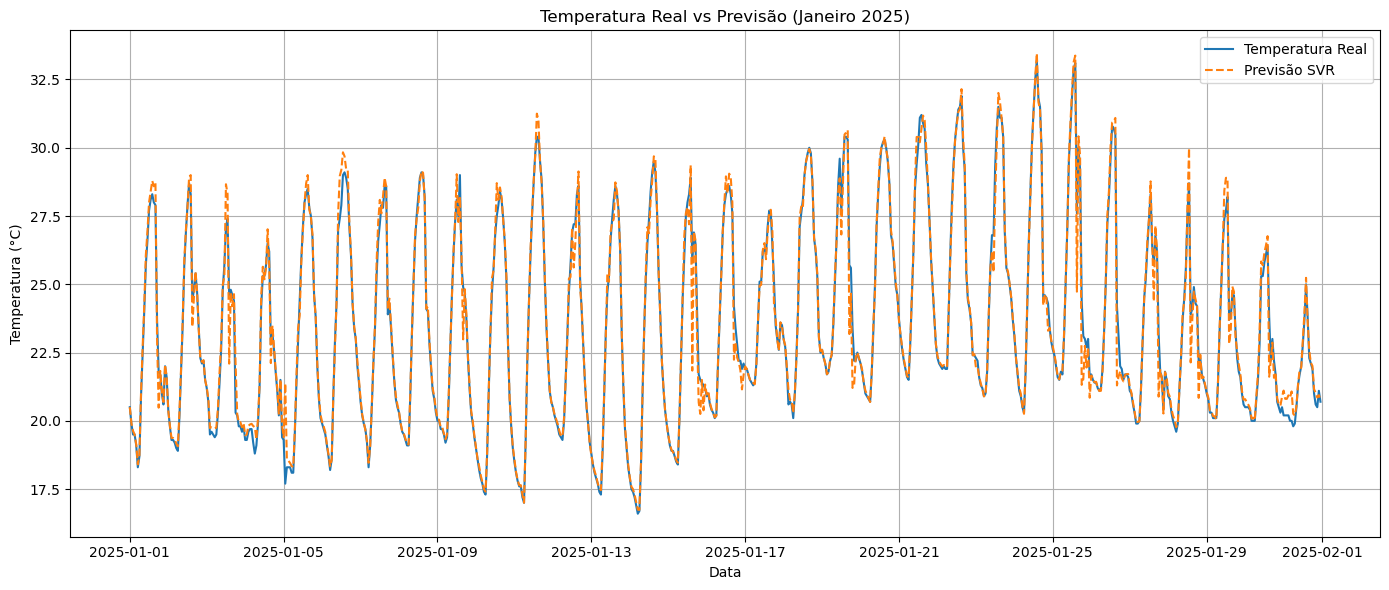

In [22]:
## dados campinas fevereiro:
urljan = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=-22.9056&longitude=-47.0608&"
    "start_date=2025-01-01&end_date=2025-01-31&"
    "hourly=temperature_2m,relative_humidity_2m,apparent_temperature,"
    "precipitation,rain,weather_code,cloud_cover,wind_direction_10m,"
    "wind_speed_10m,is_day&timezone=America%2FSao_Paulo"
)

responsejan = requests.get(urljan)
datajan = responsejan.json()

dfjan = pd.DataFrame(datajan['hourly'])
dfjan['time'] = pd.to_datetime(dfjan['time'])

dfjan['hour'] = dfjan['time'].dt.hour
dfjan['month'] = dfjan['time'].dt.month
dfjan['hour_sin'] = np.sin(2 * np.pi * dfjan['hour'] / 24)
dfjan['hour_cos'] = np.cos(2 * np.pi * dfjan['hour'] / 24)
dfjan['month_sin'] = np.sin(2 * np.pi * dfjan['month'] / 12)
dfjan['month_cos'] = np.cos(2 * np.pi * dfjan['month'] / 12)

x_inputjan = dfjan.drop(columns=['temperature_2m', 'time', 'hour', 'month'], errors='ignore')

x_scaledjan = scaler.transform(x_inputjan)
predictionsjan = model.predict(x_scaledjan)

y_truejan = dfjan['temperature_2m'].values
print("RMSE:", mean_squared_error(y_truejan, predictionsjan))
print("R² Score:", r2_score(y_truejan, predictionsjan))

plt.figure(figsize=(14, 6))
plt.plot(dfjan['time'], y_truejan, label='Temperatura Real')
plt.plot(dfjan['time'], predictionsjan, label='Previsão SVR', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura Real vs Previsão (Janeiro 2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Testando fevereiro

RMSE: 0.3746541133423822
R² Score: 0.9750537901808656


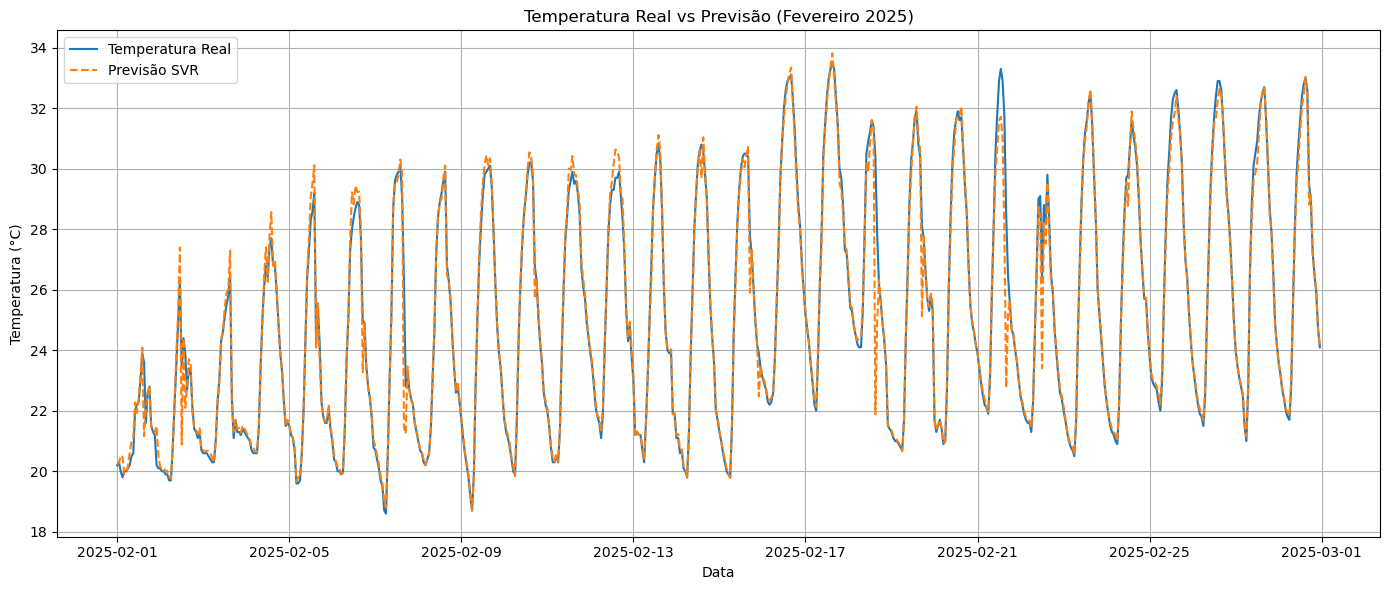

In [23]:
## dados campinas fevereiro:
urlfev = (
    "https://archive-api.open-meteo.com/v1/archive?"
    "latitude=-22.9056&longitude=-47.0608&"
    "start_date=2025-02-01&end_date=2025-02-28&"
    "hourly=temperature_2m,relative_humidity_2m,apparent_temperature,"
    "precipitation,rain,weather_code,cloud_cover,wind_direction_10m,"
    "wind_speed_10m,is_day&timezone=America%2FSao_Paulo"
)

responsefev = requests.get(urlfev)
datafev = responsefev.json()

dffev = pd.DataFrame(datafev['hourly'])
dffev['time'] = pd.to_datetime(dffev['time'])

dffev['hour'] = dffev['time'].dt.hour
dffev['month'] = dffev['time'].dt.month
dffev['hour_sin'] = np.sin(2 * np.pi * dffev['hour'] / 24)
dffev['hour_cos'] = np.cos(2 * np.pi * dffev['hour'] / 24)
dffev['month_sin'] = np.sin(2 * np.pi * dffev['month'] / 12)
dffev['month_cos'] = np.cos(2 * np.pi * dffev['month'] / 12)

x_inputfev = dffev.drop(columns=['temperature_2m', 'time', 'hour', 'month'], errors='ignore')

x_scaledfev = scaler.transform(x_inputfev)
predictionsfev = model.predict(x_scaledfev)

y_truefev = dffev['temperature_2m'].values
print("RMSE:", mean_squared_error(y_truefev, predictionsfev))
print("R² Score:", r2_score(y_truefev, predictionsfev))

plt.figure(figsize=(14, 6))
plt.plot(dffev['time'], y_truefev, label='Temperatura Real')
plt.plot(dffev['time'], predictionsfev, label='Previsão SVR', linestyle='--')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title('Temperatura Real vs Previsão (Fevereiro 2025)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()